In [32]:
%pylab inline
from wrftools import utils
import xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import wrftools

Populating the interactive namespace from numpy and matplotlib


In [2]:
wrfdata=xarray.open_dataset('/oasis/scratch/snesbitt/temp_project/WRFV3/test/blizzard/wrfout_d01_2016-02-24_00:00:00')

In [3]:
wrfdata

<xarray.Dataset>
Dimensions:                (Time: 25, bottom_top: 49, bottom_top_stag: 50, soil_layers_stag: 4, south_north: 99, south_north_stag: 100, west_east: 99, west_east_stag: 100)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 25.2909 ...
    XLONG                  (Time, south_north, west_east) float32 -106.687 ...
    XTIME                  (Time) datetime64[ns] 2016-02-24 ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 25.2744 ...
    XLONG_U                (Time, south_north, west_east_stag) float32 -106.816 ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 25.1734 ...
    XLONG_V                (Time, south_north_stag, west_east) float32 -106.668 ...
  * Time                   (Time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...
  * bottom_top             (bottom_top) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 ...
  * bottom_top_stag        (bottom_top_stag) int64 0 1 2 3 4 5 6 7 8 9 10 11 ...
  * 

/home/snesbitt/anaconda2/lib/python2.7/site-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


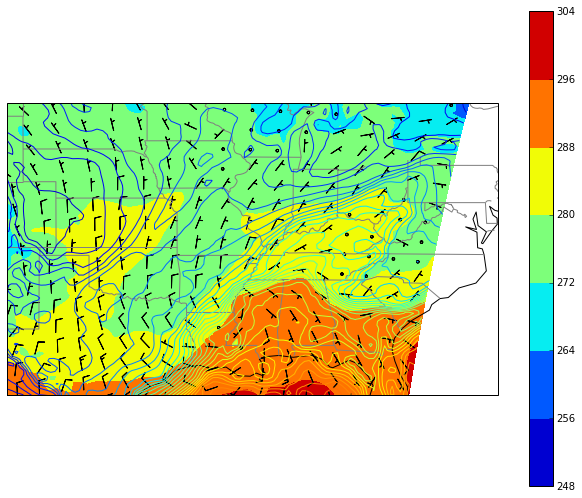

In [34]:
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

plt.figure(figsize=(11,8.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-105, -75, 28, 45])
ax.coastlines()

plt.contourf(wrfdata['XLONG'].values[0,:,:],
             wrfdata['XLAT'].values[0,:,:],
             wrfdata['T2'].values[0,:,:],transform=ccrs.PlateCarree())
plt.colorbar()
plt.barbs(wrfdata['XLONG'].values[0,::5,::5],
         wrfdata['XLAT'].values[0,::5,::5],
         U_unstag[0,0,::5,::5],V_unstag[0,0,::5,::5],transform=ccrs.PlateCarree(),
         sizes=dict(emptybarb=0.1, spacing=0.2, height=0.5),length=5)
plt.contour(wrfdata['XLONG'].values[0,:,:],
             wrfdata['XLAT'].values[0,:,:],
           1000.*wrfdata['Q2'].values[0,:,:],transform=ccrs.PlateCarree(),levels=np.arange(0,20,.5))
ax.add_feature(states_provinces, edgecolor='gray')



In [10]:
U_unstag=wrftools.utils.wrf_unstagger(wrfdata['U'].values,'U')
np.shape(U_unstag)
V_unstag=wrftools.utils.wrf_unstagger(wrfdata['V'].values,'V')
np.shape(V_unstag)

(25, 49, 99, 99)

In [22]:
## need total pressure on model vertical levels, and here we will interpolate theta
P_input = wrfdata['P'].values
PB_input = wrfdata['PB'].values
T_input = wrfdata['T'].values
## calculate pressure and potentia temperature
PRES_input = wrftools.utils.wrf_pressure( P_input, PB_input )
THETA_input = wrftools.utils.wrf_theta( T_input )
## reverse vertical order for interpolation function
PRES_input = PRES_input[ :, ::-1, :, : ]
THETA_input = THETA_input[ :, ::-1, :, : ]
## define pressure levels to interpolate to
interplevels = numpy.asarray( [ 1000, 950, 900, 850, 800, 750, 700, 650, 600, 550, 
                               500, 450, 400, 350, 300, 250, 200, 150, 100 ,50 ] )
## process potential temperature
THETA_out = wrftools.interp.wrf_to_pres( THETA_input, PRES_input, interplevels )


In [23]:
np.shape(THETA_out)

(25, 20, 99, 99)

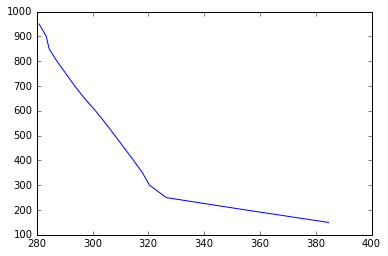

In [24]:
plt.plot(THETA_out[0,:,50,50],interplevels)